# VGG16을 활용한 식물 질병 예측 모델 구축
- 개요: 이전 전이학습 모델의 낮은 정확도를 개선하기 위해 VGG16 아키텍처와 최신 데이터셋을 활용하여 고성능 식물 질병 예측 모델을 구축
- 데이터셋: kaggle(vipoooool/new-plant-diseases-dataset)
- 프로세스 과정
    1. 학습 환경 구축
    2. 모델 구축
        1. 데이터 로드 및 전처리
        2. 모델 구조 정의
        3. 모델 학습
        4. 모델 평가
    3. 모델 개선

## 학습 환경 구축
- 환경 변수 설정
- 데이터 소스 연결 및 다운로드
- 필수 라이브러리 및 프레임워크 설치
- GPU 지원 환경 확인

### 환경변수 세팅
- 루트 디렉토리 경로: 모든 하위 경로의 기본 참조 지점
- 데이터셋 이름 : 사용할 데이터셋의 이름

In [1]:
ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/Chungbuk University/Capstone Design/AI_Model/PlantDiseaseDetection/"
DATASET_NAME = "vipoooool/new-plant-diseases-dataset"

### 데이터 소스 연결 및 다운로드
- 구글드라이브 연결: 프로젝트 소스 및 산출물 불러오기 및 저장할 장소
- 데이터셋 다운로드 : Kaggle이 제공하는 식물질병 데이터셋 다운로드
    - vipoooool/new-plant-diseases-dataset
        - class 종류 : 38개
        - 학습데이터 개수 : 70295개
        - 검증데이터 개수 : 17
Found 17572 images belonging to 38 classes.
    

In [2]:
from google.colab import drive

# Google Drive를 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [00:31<00:00, 92.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [4]:
# 필요한 데이터만 메인 폴더에 이동
!sudo mv "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)" /content/

### 필수 라이브러리 및 프레임워크 설치
주요 라이브러리 목록

    - tensorflow : 구글이 개발한 오픈소스 머신러닝 플랫폼
    - Matplotlib : 파이썬의 대표적인 시각화 라이브러리
    - Keras : 직관적인 고수준 신경망 API
    - Seaborn : 통계적 데이터 시각화에 특화된 라이브러리


In [5]:
# 주요 인공지능 라이브러리 임포트
import tensorflow as tf
import keras

# 사전 정의된 VGG16 신경망 모델 구조 임포트
from tensorflow.keras.applications import VGG16

# 신경망 구축에 필요한 레이어와 모델 관련 모듈 임포트
from tensorflow.keras import layers, models

# 이미지 데이터 로딩 및 전처리 라이브러리
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 학습 최적화 기법 Adam 임포트
from tensorflow.keras.optimizers import Adam

# 학습 결과 시각화를 위한 라이브러리
import matplotlib.pyplot as plt

# 학습률 조정 스케줄러 (지수 감소 방식)
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# 학습된 모델을 불러오는 모듈
from tensorflow.keras.models import load_model

# 조기 종료 콜백 (학습 과적합 방지)
from tensorflow.keras.callbacks import EarlyStopping

# 최적의 가중치 저장 기능 제공 콜백
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 구조를 JSON 형식으로 저장 및 로드하기 위한 모듈
from tensorflow.keras.models import model_from_json

# 기타 유틸리티 라이브러리 임포트
import os
import math
import json

### GPU 지원 환경 확인

In [6]:
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: []


## 모델 구축
1. 데이터 로드 및 전처리
2. 모델 구조 정의
3. 모델 학습
4. 모델 평가

### 데이터 로드 및 전처리
- 다운로드한 학습 및 검증 데이터를 불러와 모델 학습에 적합한 형태로 처리하고, 이를 효율적으로 활용하기 위한 이미지 데이터 로더를 생성한다.
    - 데이터셋은 이미 이미지 증강 처리가 완료된 상태이므로, 추가적인 증강 과정을 생략해도 충분하다.

In [8]:
# 데이터 로드
batch_size = 32
train_dir = '/content/New Plant Diseases Dataset(Augmented)/train'  # 학습 데이터 경로
valid_dir = '/content/New Plant Diseases Dataset(Augmented)/valid'  # 검증 데이터 경로

# 학습 데이터 생성기 (이미 증강된 데이터라면 추가 증강은 생략)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

# 검증 데이터 생성기
valid_datagen = ImageDataGenerator(rescale=1./255)

# 학습 데이터 로더
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,  # `batch_size`는 미리 정의되어 있어야 함
    class_mode='categorical'
)

# 검증 데이터 로더
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,  # `batch_size`는 동일하게 설정
    class_mode='categorical'
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
# VGG16 모델 불러오기 (include_top=False로 최상위 분류층 제외)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 전이 학습을 위해 가중치 고정

# # 새 모델 정의 -> 문제점 : base_mode을 추가하면 리스트형태로 아웃풋을 제공 이는 텐서.shape를 사용하지 못하는문제 발생
# model = models.Sequential([
#     base_model,  # VGG16 모델 추가
#     layers.Flatten(),  # Flatten 레이어로 4D 텐서를 1D로 변환
#     layers.Dense(256, activation='relu'),  # 완전 연결층
#     layers.Dropout(0.5),  # 드롭아웃으로 과적합 방지
#     layers.Dense(38, activation='softmax')  # 클래스 수가 38개인 최종 분류층
# ])

# 새 모델 정의 (Functional API 사용)
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(38, activation='softmax')(x)

model = models.Model(inputs, outputs)  # 모델 정의

# 모델 요약 확인
model.summary()  # 모델 요약 출력


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,147,238 (80.67 MB)

 Trainable params: 6,432,550 (24.54 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# 모델 구조만 따로 저장 (JSON 형식)
model_json = model.to_json()
with open('/content/drive/MyDrive/VGG/epoch_5/model_structure.json', "w") as json_file:
    json_file.write(model_json)

In [ ]:
for layer in base_model.layers:
      layer.trainable = False
      layer_output = layer.output
      print(layer.name, layer_output.shape)

input_layer (None, 224, 224, 3)
block1_conv1 (None, 224, 224, 64)
block1_conv2 (None, 224, 224, 64)
block1_pool (None, 112, 112, 64)
block2_conv1 (None, 112, 112, 128)
block2_conv2 (None, 112, 112, 128)
block2_pool (None, 56, 56, 128)
block3_conv1 (None, 56, 56, 256)
block3_conv2 (None, 56, 56, 256)
block3_conv3 (None, 56, 56, 256)
block3_pool (None, 28, 28, 256)
block4_conv1 (None, 28, 28, 512)
block4_conv2 (None, 28, 28, 512)
block4_conv3 (None, 28, 28, 512)
block4_pool (None, 14, 14, 512)
block5_conv1 (None, 14, 14, 512)
block5_conv2 (None, 14, 14, 512)
block5_conv3 (None, 14, 14, 512)
block5_pool (None, 7, 7, 512)


In [ ]:
batch_size = 34
epoch=5

In [ ]:
print(train_generator.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [ ]:
#  0.001에서 시작해보고, 필요한 경우 조금씩 낮춘다(lr을)
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
root_path = f"/content/drive/MyDrive/VGG/epoch_{epoch}/"
structure_path = root_path + "model_structure.json"
weights_path = root_path + "model_weights.weights.h5"
best_weights_path = root_path + "best_model_weights.weights.h5"
structure_weights_path = root_path + "model.keras"
history_path = root_path + "history.json"

In [ ]:
def save_model(model, history, save_path):
    # 모델을 .keras 형식으로 저장 (구조와 가중치가 함께 저장됨)
    model.save(save_path + f'model.keras')  # 모델 구조와 가중치를 함께 저장

    # 모델 구조만 따로 저장 (JSON 형식)
    model_json = model.to_json()
    with open(save_path + f'model_structure.json', "w") as json_file:
        json_file.write(model_json)

    # 모델 가중치만 따로 저장 (HDF5 형식)
    model.save_weights(save_path + f'model_weights.weights.h5')  # 가중치는 .keras 확장자를 사용할 수도 있음

    # 학습 기록 저장
    with open(save_path + 'history.json', 'w') as f:
        json.dump(history.history, f)


In [ ]:
# # EarlyStopping 콜백 설정
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def continue_training(model, save_path, total_epochs, batch_size, start_epoch=0, pre_weights_path=''):
    """
    기존 모델 학습을 이어서 진행하는 함수.

    Parameters:
    - model: Keras 모델 객체
    - save_path: 파일을 저장할 경로
    - total_epochs: 총 학습 에포크 수
    - start_epoch: 시작할 에포크 (이전 학습이 끝난 에포크)
    - batch_size: 배치 크기

    Returns:
    - history: 추가 학습 기록 객체
    """

    # 사전 학습된 가중치가 주어졌을 경우 이를 로드
    if start_epoch and os.path.exists(pre_weights_path):
        model.load_weights(pre_weights_path)
        print(f"{pre_weights_path}에서 가중치를 로드했습니다.")

    # ModelCheckpoint 콜백 설정 (가장 좋은 가중치를 저장)
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(save_path, 'best_model_weights.weights.h5'),  # 최적 가중치를 저장할 파일 경로
        monitor='val_loss',                     # 검증 손실 기준으로 가장 좋은 모델 저장
        save_best_only=True,                    # 검증 손실이 개선될 때만 저장
        save_weights_only=True,                 # 모델 가중치만 저장
        mode='min',                             # 손실이 최소가 되는 모델 선택
        verbose=1                               # 모델 저장 시 로그 출력
    )

    # 추가 학습 진행
    history = model.fit(
        train_generator,
        validation_data=valid_generator,              # 검증 데이터 설정
        steps_per_epoch=math.ceil(train_generator.samples / batch_size),  # 올림 계산
        validation_steps=math.ceil(valid_generator.samples / batch_size),  # 올림 계산
        initial_epoch=start_epoch,                    # 시작 에포크 설정
        epochs=total_epochs,                          # 총 학습 에포크
        callbacks=[checkpoint]                        # 체크포인트 콜백 추가
    )

    # 최종 모델 저장 함수 호출
    save_model(model, history, save_path, epoch)

    return history


In [ ]:
history = continue_training(model, root_path, epoch, batch_size)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.1076 - loss: 3.2453
Epoch 1: val_loss improved from inf to 2.17976, saving model to /content/drive/MyDrive/VGG/epoch_5/best_model_epoch_01.weights.h5
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 1092s 516ms/step - accuracy: 0.1076 - loss: 3.2452 - val_accuracy: 0.4007 - val_loss: 2.1798
Epoch 2/5
   1/2067 ━━━━━━━━━━━━━━━━━━━━ 5:21 156ms/step - accuracy: 0.1176 - loss: 2.8022

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 2.17976 to 2.03586, saving model to /content/drive/MyDrive/VGG/epoch_5/best_model_epoch_02.weights.h5
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.1176 - loss: 2.8022 - val_accuracy: 0.4286 - val_loss: 2.0359
Epoch 3/5
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.1682 - loss: 2.7858
Epoch 3: val_loss improved from 2.03586 to 1.91385, saving model to /content/drive/MyDrive/VGG/epoch_5/best_model_epoch_03.weights.h5
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 1112s 508ms/step - accuracy: 0.1682 - loss: 2.7858 - val_accuracy: 0.4543 - val_loss: 1.9139
Epoch 4/5
   1/2067 ━━━━━━━━━━━━━━━━━━━━ 5:15 153ms/step - accuracy: 0.1471 - loss: 2.4752
Epoch 4: val_loss did not improve from 1.91385
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - accuracy: 0.1471 - loss: 2.4752 - val_accuracy: 0.3929 - val_loss: 1.9820
Epoch 5/5
2067/2067 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.1818 - loss: 2.7254
Epoch 5: val_loss improved from 1.91385 to 1.84726,

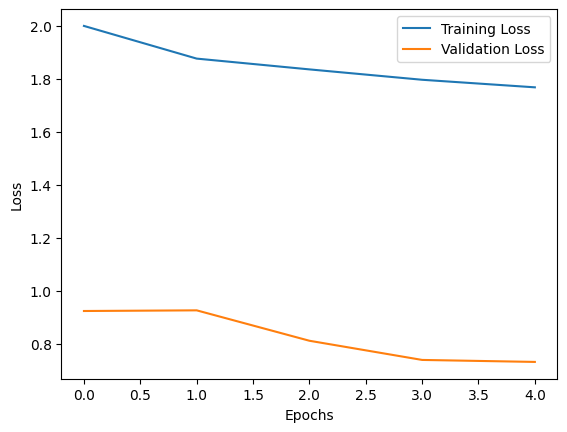

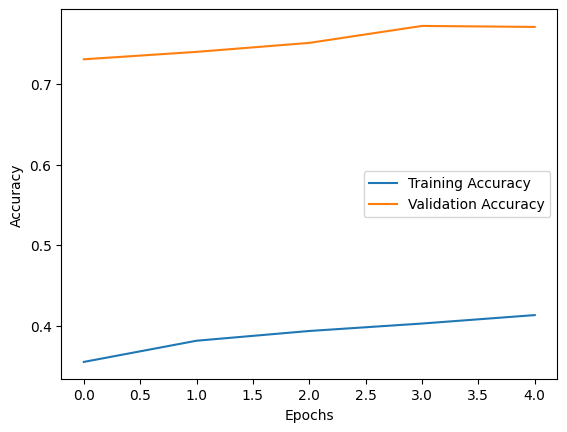

In [ ]:
# 학습 및 검증 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 학습 및 검증 정확도 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 모델 구조를 JSON 형식으로 불러오기
with open(structure_path, 'r') as json_file:
    model_json = json_file.read()
# JSON 형식으로 불러온 모델 구조를 모델 객체로 변환
model = model_from_json(model_json)

# JSON 파일 읽기
# with open('/content/drive/MyDrive/VGG/epoch_5/history.json', 'r') as f:
#     history_data = json.load(f)

# # 불러온 데이터 사용
# print(history_data)

# 모델 가중치 불러오기
model.load_weights("/content/drive/MyDrive/VGG/epoch_5/model_weights.weights.h5")

In [ ]:
# 모델 불러오기
loaded_model = keras.models.load_model('/content/drive/MyDrive/VGG/epoch_5/model.keras')

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_62>'],)
  • kwargs=<class 'inspect._empty'>

In [ ]:
# 모델 평가
# 모델 컴파일 (평가를 위한 손실 함수와 평가지표 설정)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 평가
loss, accuracy = model.evaluate(valid_generator)
print(f"손실 값: {loss}")
print(f"정확도: {accuracy}")

138/138 ━━━━━━━━━━━━━━━━━━━━ 80s 569ms/step - accuracy: 0.5403 - loss: 1.5622
손실 값: 1.5655906200408936
정확도: 0.5402344465255737
